# Results

Dropdown(description='Result', index=3, options=('/run/media/luma/Blade/Users/lumi/D/basketball_to_submit/outp…

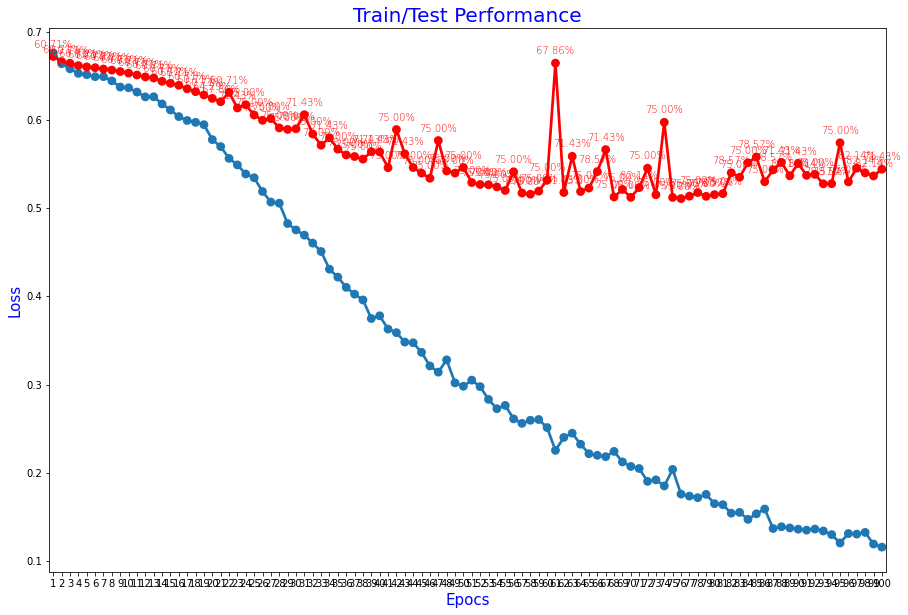

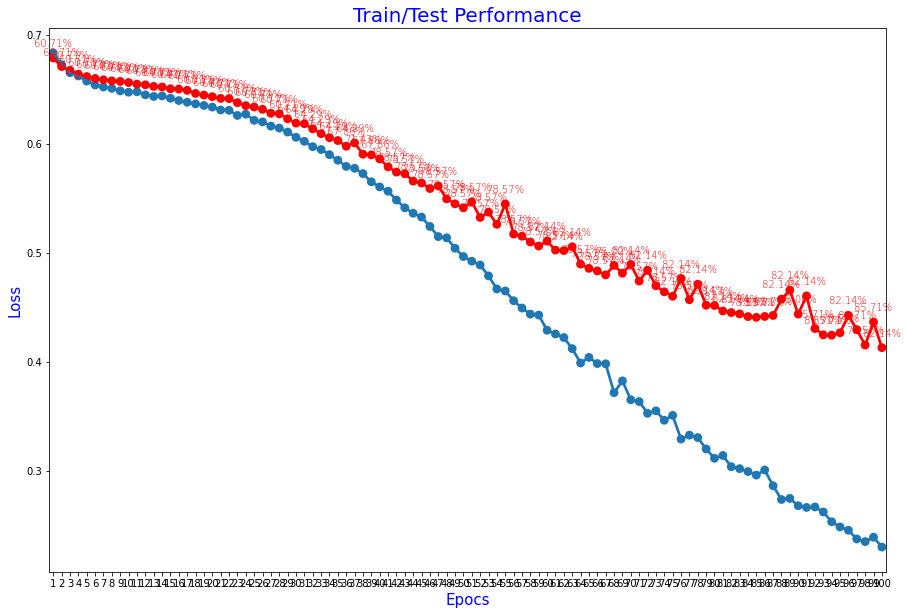

In [1]:
from IPython.display import display, clear_output
import ipywidgets as widgets
import serialize
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt


results_files_name = serialize.get_all_results_names()
results_files_name = [x for x in results_files_name if '.directory' not in x]
results_files_name.reverse()
out = widgets.Output()

w = widgets.Dropdown(
    options=results_files_name,
    description='Result',
)
def update(filename):
    data_from_csv = pd.read_csv(filename)
    f,ax1 = plt.subplots(figsize =(15,10))
    plt.title('Train/Test Performance',fontsize = 20,color='blue')
    #plt.text(0,0,'Train',color='blue',fontsize = 18)
    #plt.text(0,0,'Test',color='red',fontsize = 18)
    sns.pointplot(x='epochs',y='trainloss', data=data_from_csv)
    ax = sns.pointplot(x='epochs',y='testloss', color='red',data=data_from_csv)
    for x,y,correct,total in zip(data_from_csv['epochs'],data_from_csv['testloss'],data_from_csv['correct'],data_from_csv['test']):
        #change f'{z:.2f}' to str(z) if you want something simpler
        ax.text(x-1,y+0.01,f'{(correct/total)*100:.2f}%',horizontalalignment='center',color='red',weight='light')
    plt.xlabel('Epocs',fontsize = 15,color='blue')
    plt.ylabel('Loss',fontsize = 15,color='blue')
    display(w)
    out
    

def on_change(change):
    if change['name'] == 'value' and (change['new'] != change['old']):
        clear_output()
        update(change['new'])

w.observe(on_change)
update(results_files_name[0])

# Variables

In [ ]:
import Basketball
import time

# *************IMPORTANT*********************
# Following points are important.

# Python memory management doesnot let explicitly freeing memory. 
# So even if loaded samples are not needed and therefore can be deleted, memory will not free up. So reading new samples will be slower as  
# memory is still being used by old and garbage value. In Basketball class destroycache() function is implemented
# to delete garbage memory but in python there is no guarantee when this will happen. 
# So please take care of following points

# After background=True dataset is used then before background=False please clear memory otherwise 
# background=True frames will be returned from cache instead of background=False frames.

# After training or validating one network please clear memory before training or validating next network. 
# If using Jupyter Notebook then by restarting.

# After training for 30 frames don't train for higher than 30 frames but only lower frames.
# So always train higher frames first and then lower frames

# *************IMPORTANT*********************

start_time = time.time()
split = 'validation' #validation, training
network = "CNN3D"
background = True
dp = Basketball.Basketball(network, width=128, height=128, split=split, trajectory=False, background=background)

In [ ]:
EPOCHS = 20
dp.run(100, network, testeverytrain=True, EPOCHS=1, lr=0.0001)


In [ ]:
import gc
if 'dp' in locals():
    if dp is not None:
        dp.destroycache()
        del dp
gc.collect()
# please restart jupyter to clear memory. Python memory management
# doensot allow to explicitly free memory
# and this doesnot guarantee memory will be cleared

In [ ]:
CNN3D    EPOCS    lr
100      20       0.0001
55       20       0.0001
30       20       0.0001

CNN2DLSTM    EPOCS    lr
100      30       0.001
55       20       0.001
30       20       0.001

# Plot 

In [ ]:
#%matplotlib inline
#from IPython import display
#import torchvision.transforms.functional as F
#for batch, target in trainset:
#    print("here is the ",target)
#    view1 = batch[0]
#    for idx, img in enumerate(view1):
#        img1 = F.to_pil_image(img)
#        display.clear_output(wait=True)
#        display.display(img1.resize((320,240)), Image.NEAREST)
#    break

# Display Video

In [ ]:
#from IPython import display
#import torchvision.transforms.functional as F
#sets = DataLoader(dataset)
#for bath, target in sets:
#    print("here is the ",target)
#    view1 = batch[0][0]
#    for idx, img in enumerate(view1):
#        img1 = F.to_pil_image(img)
#        display.display(img1.resize((320,240)), Image.NEAREST)
#        display.clear_output(wait=True)
#    break

# Dataset preprocessing

In [ ]:
# Multiprocessing of different samples. Please run it from any IDE. Uses all cores for faster multiprocessing
# Two sets are created. One with background and one without background

from DataMultiProcess import DataMultiProcess
orgdata = '/run/media/luma/Blade/Users/lumi/basketball/dataset/orgdata'
save_with_background = '/home/luma/Documents/mahinelearning/basketball/dataset/background'
save_without_background = '/home/luma/Documents/mahinelearning/basketball/dataset/no_background'

# Dataset with background 
DataMultiProcess(orgdata, save_with_background + '/128x128/samples', False, (64, 128), removebackground=False).start() # For CNN3D,  CNN2DLSTM and Two stream
DataMultiProcess(orgdata, save_with_background + '/128x128_optic/samples', True, (64, 128), removebackground=False).start() # this needed for Two stream
DataMultiProcess(orgdata, save_with_background +  '/48x48/samples', False, (24, 48), removebackground=False).start() # Run this for FFNN

# Dataset without background 
DataMultiProcess(orgdata, save_without_background + '/128x128/samples', False, (64, 128), removebackground=True).start() # For CNN3D,  CNN2DLSTM and Two stream
DataMultiProcess(orgdata, save_without_background + '/128x128_optic/samples', True, (64, 128), removebackground=True).start() # this needed for Two stream
DataMultiProcess(orgdata, save_without_background + '/48x48/samples', False, (24, 48), removebackground=True).start() # Run this for FFNN


# Models

Initialize weights
image preprocessing
normalizing the inputs
regularizations

inceptio v4
inceptionv4
resnet 101
resnet 152

1x1 convolution

efficient architectures
How do we obtain networks that are computationally and memory efficient
enough to run on mobile devices, possibly with limited power supply?

Width multiplier:
Reduce the number of channels in each layer. This has been
called width multiplier in „MobileNets: Efficient Convolutional Neural Networks
for Mobile Vision Applications“.
What is the effect on the computational complexity and on the parameters?

resolution multiplier 
Reduce the resolution of the input image. This has been called
resolution multiplier in „MobileNets: Efficient Convolutional Neural Networks for
Mobile Vision Applications“.




Direct approach
Model based approach
Model and learning-based approach

https://paperswithcode.com/paper/quo-vadis-action-recognition-a-new-model-and

1. [Implemented] Feed Forward Neural Network (FFNN)
View 1 and View 2 are concatenated side by side at first and each of the samples are then also concatenated. In this way a vector 
is formed which is then feed to the Feed Forward Neural Network(FFNN). Other variation could be going deep with multiple hidden layers
2. CNN2  [Implemented]
    view1->conv3d
    view2->conv3d-------------> these are somehow combined and 
    optical(view1) -> conv3d--> flatted to predict 2 classes
    optical(view2) -> conv3d
3. CNN3 [Implemented] (use LTSM) -> https://github.com/HHTseng/video-classification
    encode each frame with conv2d and send the output to be decoded to a lstm
4. CNN4 [Implemented]
    view1 and view2 and concatinated side by side and feed through the conv3d and flattened feed through linear layer

Regularization: Adding a term to a loss function that penalizes for high weights. It tradies in some of the ability to fit the training data well for the ability to have a model generalize better to the data it has not seen before.
E(Theta) = Sum of all inputs((target - input) ** 2 ) + (lamda/2*m) * weights**2

Generalization:
    It is a technique to ensure that architecture as well as the training data are chosen in such as way that the network makes a good prediction during training.
    1. Validate: Without validation it is impossible to judge whether my model is reasonable or starts overfitting the data. 
    2. Agumentation.
    3. Ensemble learning
    4. Dropout
    5. Regularization with a penalty
    6. Data augmentation
    7. Early stopping

In [ ]:
import matplotlib.pyplot as plt
import scipy.stats
import numpy as np

data = torch.load("diwas.pt")
mean = np.array([0.5968847986774942, 0.595796225058005, 0.5962871697447794]).reshape(3,1,1)
mean = mean.mean()
std = np.array([0.261574085266821, 0.2626656457308586, 0.26264871624129915]).reshape(3,1,1)
std = std.std()

x_min = data.min()
x_max = data.max()


x = np.array(data)
x = x.mean(0)

y = scipy.stats.norm.pdf(x,mean,std)

plt.plot(x,y, color='coral')

plt.grid()

plt.xlim(x_min,x_max)



plt.xlabel('x')
plt.ylabel('Normal Distribution')

plt.savefig("normal_distribution.png")
plt.show()

In [ ]:
x.mean(0).shape

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import scipy.stats
import torch
import numpy as np
import torchvision


img = Image.open("dataset/background/data/samples/training/hit/0/00.png") 
#data = torchvision.transforms.ToTensor()(img)
data = np.array(img)
data = torch.FloatTensor(data)

mean = data.mean()
std =  data.std()

x = data.view(-1)

x_min = data.min()
x_max = data.max()



y = scipy.stats.norm.pdf(x,mean,std)

plt.plot(x,y, color='coral')

plt.grid()

plt.xlim(x_min,x_max)

plt.xlabel('x')
plt.ylabel('Normal Distribution')

#plt.savefig("normal_distribution.png")
plt.show()

In [ ]:
img = Image.open("dataset/background/data/samples/training/hit/0/00.png") 
#data = torchvision.transforms.ToTensor()(img)
data = np.array(img)
data = torch.FloatTensor(data)

mean = data.mean()
std =  data.std()

x = data.view(-1)

x_min = data.min()
x_max = data.max()

In [ ]:
mean

In [ ]:
data.view(-1)

In [ ]:
a = ["asdf","erw","as"]

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import math
img = Image.open("dataset/background/data/samples/training/hit/0/00.png")


mu = 0
variance = 1
sigma = math.sqrt(variance)
tensornormalize = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])

mean = [0,0,0]
std = [0,0,0]
for i in range(data.shape[0]):
    mean[i] = data[i].mean()
    std[i] = data[i].std()
        
data = tensornormalize(img)
tensornormalize = torchvision.transforms.Compose([
    torchvision.transforms.Normalize(mean[0], std[0])
])
data = tensornormalize(data)
#x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
x = data.flatten()
plt.plot(x, stats.norm.pdf(x, mu, sigma))
plt.show()

In [ ]:
data[0].shape

In [4]:
import serialize
import os
import os
import serialize
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

def saveResultasImage(hundred_all, fiftyfive_all, thirty_all):
    hundred_path = hundred_all[0][0]
    fiftyfive_path = fiftyfive_all[0][0]
    thirty_path = thirty_all[0][0]
    filename = hundred_path.split(os.sep)[-5].upper() + " " + hundred_path.split(os.sep)[-4].upper() 
    hundred = pd.read_csv(hundred_path)
    fiftyfive = pd.read_csv(fiftyfive_path)
    thirty = pd.read_csv(thirty_path)

    hundred_pre = hundred_all[1][0].split(os.sep)[-1].split("_")[0]
    fiftyfive_pre = fiftyfive_all[1][0].split(os.sep)[-1].split("_")[0]
    thirty_pre = thirty_all[1][0].split(os.sep)[-1].split("_")[0]

    f,ax1 = plt.subplots(2,2,figsize =(15,10))
    f.suptitle(filename, fontsize=16)
    a1 = sns.pointplot(x='epochs',y='trainloss', data=hundred, ax=ax1[0][0])
    a = sns.pointplot(x='epochs',y='testloss', color='red',data=hundred, ax=ax1[0][0])
    a1.set(xlabel='Epochs', ylabel='Loss')
    a1.set_title(hundred_path.split(os.sep)[-3] + " frames")

    a2 = sns.pointplot(x='epochs',y='trainloss', data=fiftyfive, ax=ax1[0][1])
    a = sns.pointplot(x='epochs',y='testloss', color='red',data=fiftyfive, ax=ax1[0][1])
    a2.set(xlabel='Epochs', ylabel='Loss')
    a2.set_title(fiftyfive_path.split(os.sep)[-3] + " frames")

    a3 = sns.pointplot(x='epochs',y='trainloss', data=thirty, ax=ax1[1][0])
    a = sns.pointplot(x='epochs',y='testloss', color='red',data=thirty, ax=ax1[1][0])
    a3.set(xlabel='Epochs', ylabel='Loss')
    a3.set_title(thirty_path.split(os.sep)[-3] + " frames")
    ax1[-1, -1].axis('off')
    test_patch = mpatches.Patch(color='red', label='Test')
    train_patch = mpatches.Patch(color='blue', label='Train')
    plt.legend(handles=[train_patch, test_patch])
    
    plt.text(0,0.3,'Validation ',color='black',fontsize = 18)
    plt.text(0,0.2,hundred_path.split(os.sep)[-3] + ' Frames: ' + hundred_pre,color='black',fontsize = 18)
    plt.text(0,0.1,'55 Frames:  ' + fiftyfive_pre,color='black',fontsize = 18)
    plt.text(0,0,'30 Frames:  ' + thirty_pre,color='black',fontsize = 18)
   

    #plt.show()
    outputfolder = "resultimage"
    if not os.path.exists(outputfolder):
        os.makedirs(outputfolder)
    save_path = os.path.join(outputfolder,  filename + ".png")
    plt.savefig(save_path)
    plt.clf()

modules = ["FFNN", "CNN2DLSTM", "CNN3D", "TWOSTREAM", "POSITIONFFNN", "POSITIONLSTM"]
trajectories = [False, False, False, False, True, True]
frames = [100, 55, 30]
backgrounds = [True, False, None]
results_files_name = serialize.get_all_results_names()
predictions_files_name = serialize.get_all_predictions_names()

def getnetworkresults(listoffiles, module, trajectory, num_frames, background, typeresult):
    files = []
    backgroundpath = "trajectory"
    if trajectory == False:
        if background == True:
            backgroundpath = "background"
        elif background == False:
            backgroundpath = "no_background"
    for path in listoffiles:
        pathsplit = path.split(os.sep)
        if backgroundpath in pathsplit and str(num_frames) in pathsplit and module in pathsplit and typeresult in pathsplit:
            files.append(path)
    if len(files) == 0:
        raise FileNotFoundError("No data were found.")
    return files
i = 1
one_network = []
for background in backgrounds:
    for module, trajectory in zip(modules, trajectories):
        for frame in frames:
            if (trajectory == True and frame == 100) or (background == False and frame == 100):
                frame = 99
            if background is not None and trajectory == True:
                continue
            if background is None and trajectory == False:
                continue
            net = getnetworkresults(results_files_name, module, trajectory, frame, background, "results")
            pre = getnetworkresults(predictions_files_name, module, trajectory, frame, background, "predictions")
            one_network.append([net, pre])
            if len(one_network) == 3:
                saveResultasImage(one_network[0], one_network[1], one_network[2])
                one_network = []
                i = 2

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>